# **Imports**

In [8]:
import pandas as pd
from sklearn import datasets
import numpy as np
import math
import matplotlib.pyplot as plt
from K_means import *
from sklearn.datasets import make_blobs
from numpy import dot
from numpy.linalg import norm
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler, normalize
from scipy.sparse.linalg import eigs, eigsh
from scipy.spatial.distance import cdist
from sklearn.impute import KNNImputer
from sklearn.metrics import rand_score
from spectral_functions import *
import tqdm

# **Data generation**

In [16]:
n_samples = 500
n_features = 20
n_clusters = 4

X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, random_state=42)

df = pd.DataFrame(X)
df['True_Label'] = y

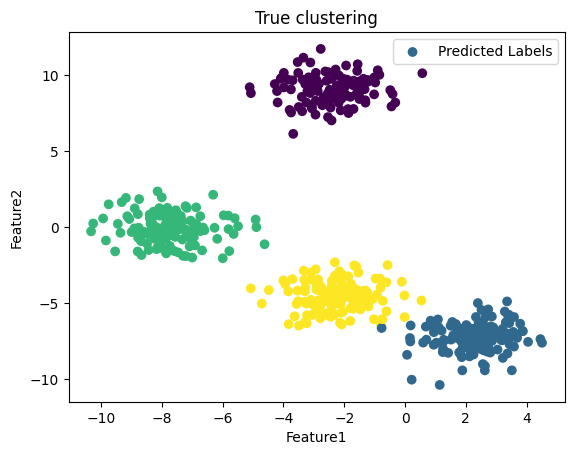

In [17]:
plt.scatter(df[0], df[1], c=df['True_Label'], cmap='viridis', label='Predicted Labels')
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.title('True clustering')
plt.legend()
plt.show()

In [18]:
# define noise level
noise_level = 2

# initial synthetic data
X_raw, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, random_state=42)
sc = StandardScaler()
sc.fit(X_raw)
X = sc.transform(X_raw)

# add homoscedatic noise
X_noisy_homoscedastic_raw = X + noise_level * np.random.randn(n_samples, n_features)
sc.fit(X_noisy_homoscedastic_raw)
X_noisy_homoscedastic = sc.transform(X_noisy_homoscedastic_raw)

# normalize data
X_centered = X - X.mean(axis=0)

# add heteroskedastic noise (correlated to the value)
X_noisy_heteroscedastic_raw = X + noise_level * np.random.randn(n_samples, n_features) * X
sc.fit(X_noisy_heteroscedastic_raw)
X_noisy_heteroscedastic = sc.transform(X_noisy_heteroscedastic_raw)

# **Measures**

## **Between models**

### **Regular kmeans**

In [19]:
# stock loss
loss_kmeans = []

# stock accuracy 
accuracy_kmeans = []

# std K-means
kmeans_original = generalized_Kmeans(k=n_clusters, init='forgy', random_seed=42)
kmeans_original.fit(X)
y_original = kmeans_original.predict(X)


# stock loss
loss_kmeans.append(kmeans_original.loss_)
#stock accuracy
accuracy_kmeans.append(rand_score(y, y_original))

# std K-means on homoscedastic noised data
kmeans_homoscedastic = generalized_Kmeans(k=n_clusters, init='forgy', random_seed=42)
kmeans_homoscedastic.fit(X_noisy_homoscedastic)
y_homoscedastic = kmeans_homoscedastic.predict(X_noisy_homoscedastic)

# stock loss
loss_kmeans.append(kmeans_homoscedastic.loss_)
#stock accuracy
accuracy_kmeans.append(rand_score(y, y_homoscedastic))

# std K-means on heteroscedatic noised data
kmeans_heteroscedastic = generalized_Kmeans(k=n_clusters, init='forgy', random_seed=42)
kmeans_heteroscedastic.fit(X_noisy_heteroscedastic)
y_heteroscedastic = kmeans_heteroscedastic.predict(X_noisy_heteroscedastic)

# stock loss
loss_kmeans.append(kmeans_heteroscedastic.loss_)
#stock accuracy
accuracy_kmeans.append(rand_score(y, y_heteroscedastic))

### **Kmeans ++**

In [20]:
# stock loss
loss_kmeans_pp = []
accuracy_kmeans_pp = []

# K-means++
kmeans_pp = generalized_Kmeans(k=n_clusters, init='kmeans++', random_seed=42)
kmeans_pp.fit(X)
y_pp_original = kmeans_pp.predict(X)

# stock loss
loss_kmeans_pp.append(kmeans_pp.loss_)
#stock accuracy
accuracy_kmeans_pp.append(rand_score(y, y_pp_original))

# K-means++ on homoscedastic noised data
kmeans_pp_homoscedastic = generalized_Kmeans(k=n_clusters, init='kmeans++', random_seed=42)
kmeans_pp_homoscedastic.fit(X_noisy_homoscedastic)
y_pp_homoscedastic = kmeans_pp_homoscedastic.predict(X_noisy_homoscedastic)

# stock loss
loss_kmeans_pp.append(kmeans_pp_homoscedastic.loss_)
#stock accuracy
accuracy_kmeans_pp.append(rand_score(y, y_pp_homoscedastic))

# K-means++ on heteroscedatic noised data
kmeans_pp_heteroscedastic = generalized_Kmeans(k=n_clusters, init='kmeans++', random_seed=42)
kmeans_pp_heteroscedastic.fit(X_noisy_heteroscedastic)
y_pp_heteroscedastic = kmeans_pp_heteroscedastic.predict(X_noisy_heteroscedastic)

# stock loss
loss_kmeans_pp.append(kmeans_pp_heteroscedastic.loss_)
#stock accuracy
accuracy_kmeans_pp.append(rand_score(y, y_pp_heteroscedastic))

### **Guided PCA**

In [21]:
# stock loss
loss_kmeans_pca = []
accuracy_kmeans_pca = []

# K-means++
kmeans_pca = generalized_Kmeans(k=n_clusters, init='guided_PCA', random_seed=42)
kmeans_pca.fit(X)
y_pca_original = kmeans_pca.predict(X)

# stock loss
loss_kmeans_pca.append(kmeans_pca.loss_)
#stock accuracy
accuracy_kmeans_pca.append(rand_score(y, y_pca_original))

# K-means++ on homoscedastic noised data
kmeans_pca_homoscedastic = generalized_Kmeans(k=n_clusters, init='guided_PCA',  random_seed=42)
kmeans_pca_homoscedastic.fit(X_noisy_homoscedastic)
y_pca_homoscedastic = kmeans_pca_homoscedastic.predict(X_noisy_homoscedastic)

# stock loss
loss_kmeans_pca.append(kmeans_pca_homoscedastic.loss_)
#stock accuracy
accuracy_kmeans_pca.append(rand_score(y, y_pca_homoscedastic))

# K-means++ on heteroscedatic noised data
kmeans_pca_heteroscedastic = generalized_Kmeans(k=n_clusters, init='guided_PCA', random_seed=42)
kmeans_pca_heteroscedastic.fit(X_noisy_heteroscedastic)
y_pca_heteroscedastic = kmeans_pca_heteroscedastic.predict(X_noisy_heteroscedastic)

# stock loss
loss_kmeans_pca.append(kmeans_pca_heteroscedastic.loss_)
#stock accuracy
accuracy_kmeans_pca.append(rand_score(y, y_pca_heteroscedastic))

### **Spectral**

In [22]:
# stock loss
loss_kmeans_spectral = []
accuracy_kmeans_spectral = []

# spectral clustering
labels = final_spectral_clustering_sym(X, euclidian_similarity_function, k_nearest_neighboors= 5, number_of_clusters= n_clusters, weighted=True, eigensolver= compute_matrix_U_ARPACK)
loss = loss_inertia(labels, X)
y_spectral_original = labels

# stock loss
loss_kmeans_spectral.append(loss)
#stock accuracy
accuracy_kmeans_spectral.append(rand_score(y, y_spectral_original))

# spectral clustering on homoscedastic noised data
labels = final_spectral_clustering_sym(X_noisy_homoscedastic, euclidian_similarity_function, k_nearest_neighboors= 5, number_of_clusters= n_clusters, weighted=True, eigensolver= compute_matrix_U_ARPACK)
loss = loss_inertia(labels, X_noisy_homoscedastic)
y_spectral_homoscedastic = labels

# stock loss
loss_kmeans_spectral.append(loss)
#stock accuracy
accuracy_kmeans_spectral.append(rand_score(y, y_spectral_homoscedastic))

# spectral clustering on heteroscedatic noised data
labels = final_spectral_clustering_sym(X_noisy_heteroscedastic, euclidian_similarity_function, k_nearest_neighboors= 5, number_of_clusters= n_clusters, weighted=True, eigensolver= compute_matrix_U_ARPACK)
loss = loss_inertia(labels, X_noisy_heteroscedastic)
y_spectral_heteroscedastic = labels

# stock loss
loss_kmeans_spectral.append(loss)
#stock accuracy
accuracy_kmeans_spectral.append(rand_score(y, y_spectral_heteroscedastic))

### **Visualization**

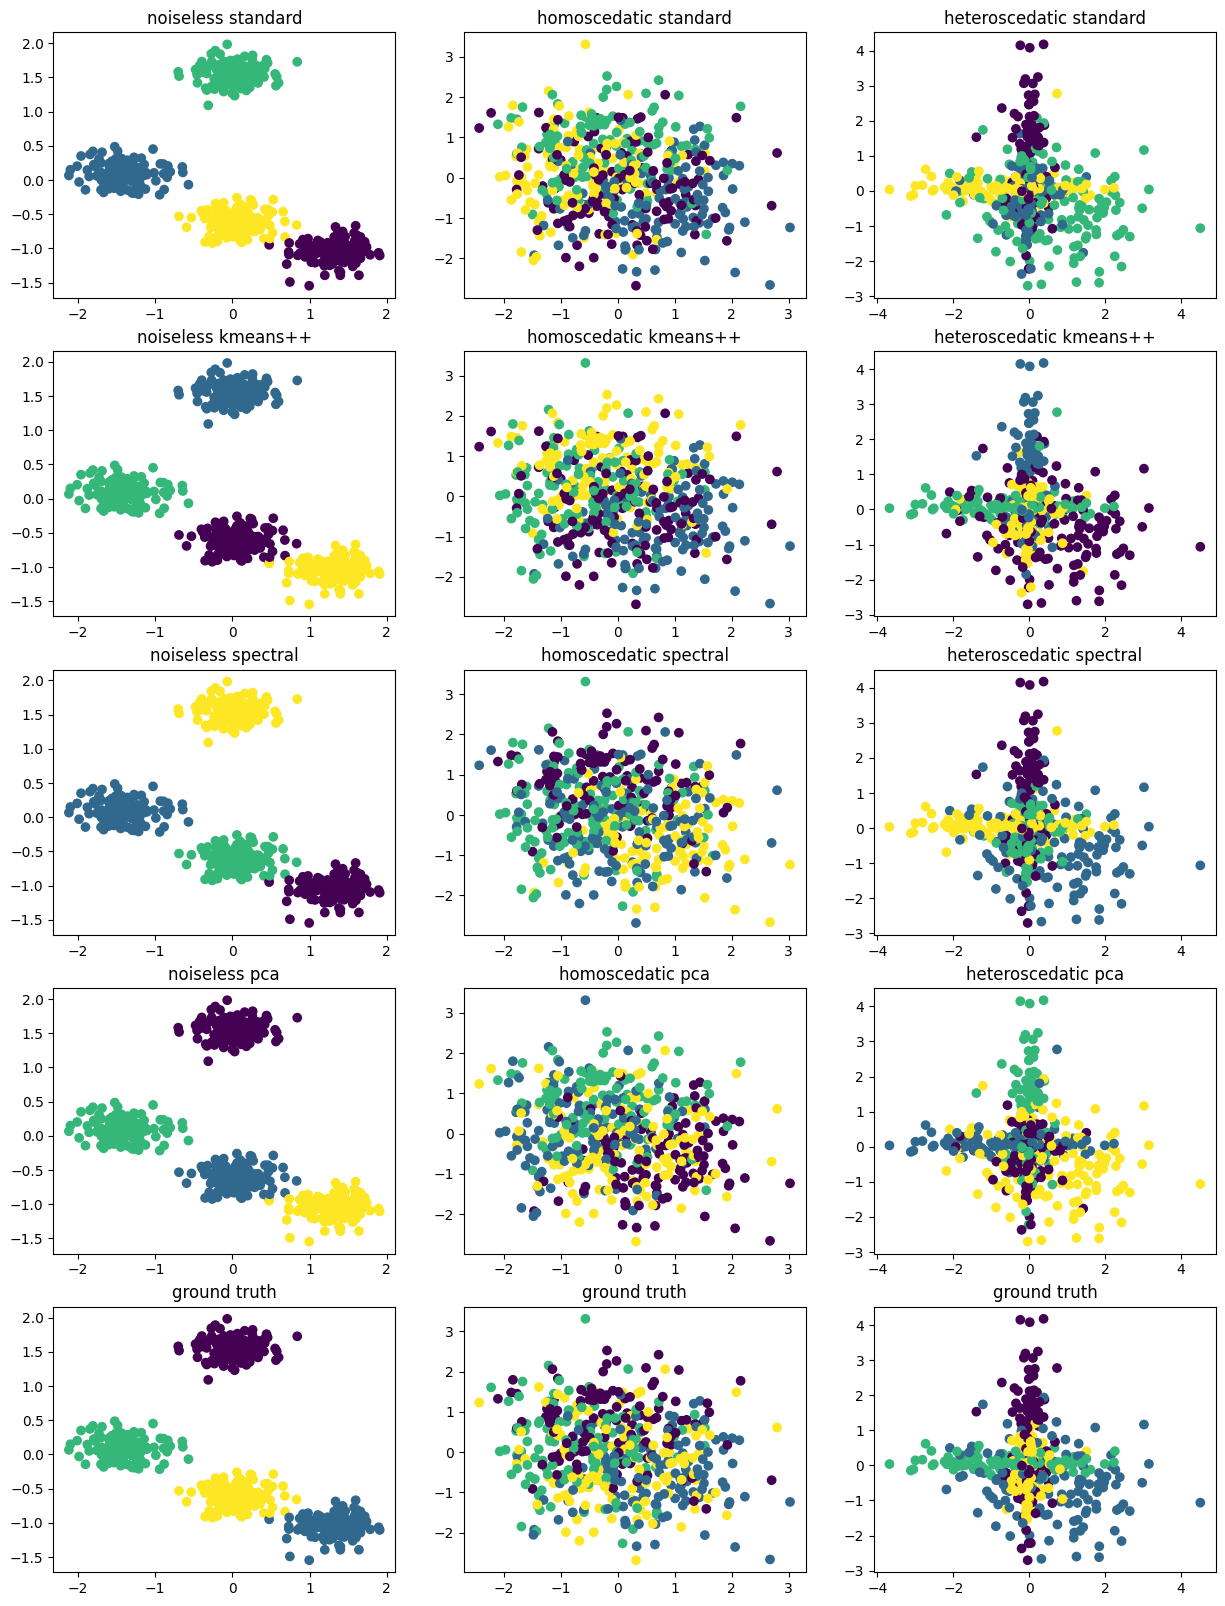

In [23]:
# print clustering
fig = plt.figure(figsize=(15, 20))
axes = fig.subplots(nrows=5, ncols=3)

ax=axes[0,0]
ax.scatter(X[:, 0], X[:, 1], c=y_original, cmap='viridis')
ax.set_title('noiseless standard')

ax=axes[0,1]
ax.scatter(X_noisy_homoscedastic[:, 0], X_noisy_homoscedastic[:, 1], c=y_homoscedastic, cmap='viridis')
ax.set_title('homoscedatic standard')

ax=axes[0,2]
ax.scatter(X_noisy_heteroscedastic[:, 0], X_noisy_heteroscedastic[:, 1], c=y_heteroscedastic, cmap='viridis')
ax.set_title('heteroscedatic standard')

ax=axes[1,0]
ax.scatter(X[:, 0], X[:, 1], c=y_pp_original, cmap='viridis')
ax.set_title('noiseless kmeans++')

ax=axes[1,1]
ax.scatter(X_noisy_homoscedastic[:, 0], X_noisy_homoscedastic[:, 1], c=y_pp_homoscedastic, cmap='viridis')
ax.set_title('homoscedatic kmeans++')

ax=axes[1,2]
ax.scatter(X_noisy_heteroscedastic[:, 0], X_noisy_heteroscedastic[:, 1], c=y_pp_heteroscedastic, cmap='viridis')
ax.set_title('heteroscedatic kmeans++')

ax=axes[2,0]
ax.scatter(X[:, 0], X[:, 1], c=y_spectral_original, cmap='viridis')
ax.set_title('noiseless spectral')

ax=axes[2,1]
ax.scatter(X_noisy_homoscedastic[:, 0], X_noisy_homoscedastic[:, 1], c=y_spectral_homoscedastic, cmap='viridis')
ax.set_title('homoscedatic spectral')

ax=axes[2,2]
ax.scatter(X_noisy_heteroscedastic[:, 0], X_noisy_heteroscedastic[:, 1], c=y_spectral_heteroscedastic, cmap='viridis')
ax.set_title('heteroscedatic spectral')

ax=axes[3,0]
ax.scatter(X[:, 0], X[:, 1], c=y_pca_original, cmap='viridis')
ax.set_title('noiseless pca')

ax=axes[3,1]
ax.scatter(X_noisy_homoscedastic[:, 0], X_noisy_homoscedastic[:, 1], c=y_pca_homoscedastic, cmap='viridis')
ax.set_title('homoscedatic pca')

ax=axes[3,2]
ax.scatter(X_noisy_heteroscedastic[:, 0], X_noisy_heteroscedastic[:, 1], c=y_pca_heteroscedastic, cmap='viridis')
ax.set_title('heteroscedatic pca')

ax=axes[4,0]
ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
ax.set_title('ground truth')

ax=axes[4,1]
ax.scatter(X_noisy_homoscedastic[:, 0], X_noisy_homoscedastic[:, 1], c=y, cmap='viridis')
ax.set_title('ground truth')

ax=axes[4,2]
ax.scatter(X_noisy_heteroscedastic[:, 0], X_noisy_heteroscedastic[:, 1], c=y, cmap='viridis')
ax.set_title('ground truth')

plt.show()

### **Compare loss and accuracy**

In [24]:
# print loss
print(f'loss of standard k-means:', loss_kmeans)

# print accuracy
print(f'accuracy of standard k-means:', accuracy_kmeans, '\n')

# print loss
print(f'loss of k-means++:', loss_kmeans_pp)

# print accuracy
print(f'accuracy of k-means++:', accuracy_kmeans_pp, '\n')

# print loss
print(f'loss of spectral k-means:', loss_kmeans_spectral)

# print accuracy
print(f'accuracy of spectral k-means:', accuracy_kmeans_spectral, '\n')

# print loss
print(f'loss of pca-guided k-means:', loss_kmeans_pca)

# print accuracy
print(f'accuracy of pca-guided k-means:', accuracy_kmeans_pca, '\n')

loss of standard k-means: [631.0528898661045, 7962.912599678632, 7872.580678779515]
accuracy of standard k-means: [1.0, 0.8836953907815631, 0.8633667334669338] 

loss of k-means++: [631.0528898661045, 7962.977881339839, 7873.046322352941]
accuracy of k-means++: [1.0, 0.8870140280561122, 0.8648657314629259] 

loss of spectral k-means: [631.0528898661045, 8104.672842739337, 7973.397733078785]
accuracy of spectral k-means: [1.0, 0.8610901803607215, 0.9351983967935872] 

loss of pca-guided k-means: [631.0528898661045, 7963.74964860563, 7876.4032339057185]
accuracy of pca-guided k-means: [1.0, 0.886805611222445, 0.8725691382765531] 



### **Compare different k**

In [25]:
accuracy_original = []
accuracy_homoscedastic = []
accuracy_heteroscedastic = []
random = []

for k in range(3, 20) :

    # spectral clustering
    labels = final_spectral_clustering_sym(X, euclidian_similarity_function, k_nearest_neighboors= k, number_of_clusters= n_clusters, weighted=False, eigensolver= compute_matrix_U_ARPACK)
    y_spectral_original = labels
    accuracy_original.append(rand_score(y, y_spectral_original))

    # spectral clustering on homoscedastic noised data
    labels = final_spectral_clustering_sym(X_noisy_homoscedastic, euclidian_similarity_function, k_nearest_neighboors= k, number_of_clusters= n_clusters, weighted=False, eigensolver= compute_matrix_U_ARPACK)
    y_spectral_homoscedastic = labels
    accuracy_homoscedastic.append(rand_score(y, y_spectral_homoscedastic))

    # spectral clustering on heteroscedatic noised data
    labels = final_spectral_clustering_sym(X_noisy_heteroscedastic, euclidian_similarity_function, k_nearest_neighboors= k, number_of_clusters= n_clusters, weighted=False, eigensolver= compute_matrix_U_ARPACK)
    y_spectral_heteroscedastic = labels
    accuracy_heteroscedastic.append(rand_score(y, y_spectral_heteroscedastic))

    # random clustering for comparison
    random.append(rand_score(y, np.random.randint(low=0, high = 3, size = y.shape[0])))
    

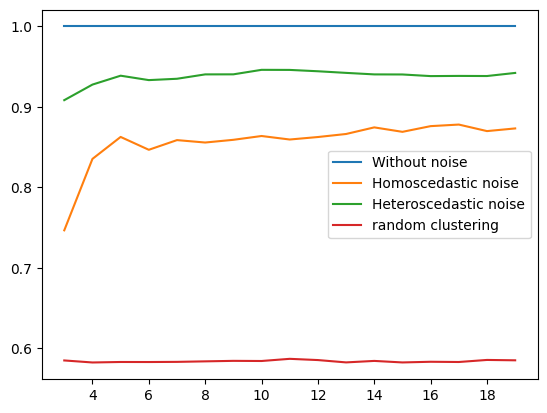

In [26]:
plt.plot(list(range(3, 20)), accuracy_original, label = 'Without noise')
plt.plot(list(range(3, 20)), accuracy_homoscedastic, label = 'Homoscedastic noise')
plt.plot(list(range(3, 20)), accuracy_heteroscedastic, label = 'Heteroscedastic noise')

plt.plot(list(range(3, 20)), random, label = 'random clustering')

plt.legend()
plt.show()

### **Inlfuence of the number of clusters**

We will compare on the heteroscedastic noise :

In [27]:
n_samples = 500
n_features = 20
noise_level = 2

accuracy_kmeans = []
accuracy_kmeans_pp = []
accuracy_spectral = []
accuracy_kmeans_pca = []

for cluster_number in range(1, 10) :

    n_clusters = cluster_number

    # initial synthetic data
    X_raw, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, random_state=42)
    sc = StandardScaler()
    sc.fit(X_raw)
    X = sc.transform(X_raw)

    # add homoscedatic noise
    X_noisy_heteroscedastic_raw = X + noise_level * np.random.randn(n_samples, n_features) * X
    sc.fit(X_noisy_heteroscedastic_raw)
    X_noisy_heteroscedastic = sc.transform(X_noisy_heteroscedastic_raw)

    # spectral clustering on heteroscedastic noised data
    labels = final_spectral_clustering_sym(X_noisy_heteroscedastic, euclidian_similarity_function, k_nearest_neighboors= 7, number_of_clusters= n_clusters, weighted=True, eigensolver= compute_matrix_U_ARPACK)
    y_spectral_heteroscedastic = labels
    accuracy_spectral.append(rand_score(y, y_spectral_heteroscedastic))

    kmeans_heteroscedastic = generalized_Kmeans(k=n_clusters, init='forgy', random_seed=42)
    kmeans_heteroscedastic.fit(X_noisy_heteroscedastic)
    y_heteroscedastic = kmeans_heteroscedastic.predict(X_noisy_heteroscedastic)
    accuracy_kmeans.append(rand_score(y, y_heteroscedastic))

    kmeans_pp_heteroscedastic = generalized_Kmeans(k=n_clusters, init='kmeans++', random_seed=42)
    kmeans_pp_heteroscedastic.fit(X_noisy_heteroscedastic)
    y_pp_heteroscedastic = kmeans_pp_heteroscedastic.predict(X_noisy_heteroscedastic)
    accuracy_kmeans_pp.append(rand_score(y, y_pp_heteroscedastic))

    # K-means++ on heteroscedatic noised data
    kmeans_pca_heteroscedastic = generalized_Kmeans(k=n_clusters, init='guided_PCA', random_seed=42)
    kmeans_pca_heteroscedastic.fit(X_noisy_heteroscedastic)
    y_pca_heteroscedastic = kmeans_pca_heteroscedastic.predict(X_noisy_heteroscedastic)
    accuracy_kmeans_pca.append(rand_score(y, y_pca_heteroscedastic))
    

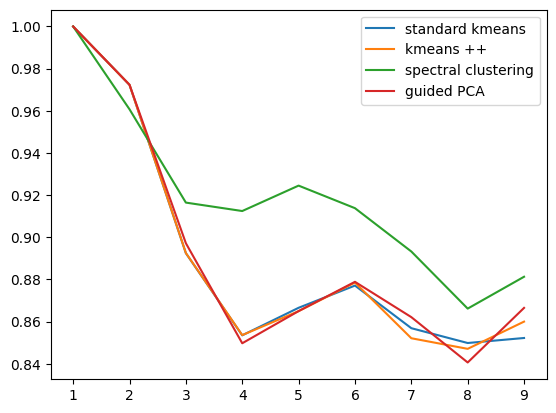

In [28]:
plt.plot(list(range(1, 10)), accuracy_kmeans, label = 'standard kmeans')
plt.plot(list(range(1, 10)), accuracy_kmeans_pp, label = 'kmeans ++')
plt.plot(list(range(1, 10)), accuracy_spectral, label = 'spectral clustering')
plt.plot(list(range(1, 10)), accuracy_kmeans_pca, label = 'guided PCA')

plt.legend()
plt.show()

### **Influence of the number of features**

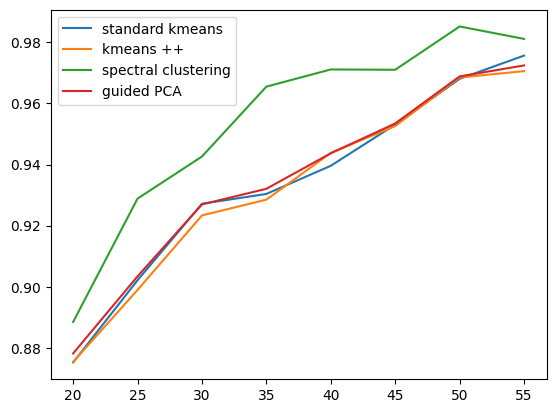

In [29]:
n_samples = 1000
n_clusters = 10
noise_level = 2

accuracy_kmeans = []
accuracy_kmeans_pp = []
accuracy_spectral = []
accuracy_kmeans_pca = []

for feature_number in range(20, 60, 5) :

    n_clusters = cluster_number

    # initial synthetic data
    X_raw, y = make_blobs(n_samples=n_samples, n_features=feature_number, centers=n_clusters, random_state=42)
    sc = StandardScaler()
    sc.fit(X_raw)
    X = sc.transform(X_raw)

    # add homoscedatic noise
    X_noisy_heteroscedastic_raw = X + noise_level * np.random.randn(n_samples, feature_number) * X
    sc.fit(X_noisy_heteroscedastic_raw)
    X_noisy_heteroscedastic = sc.transform(X_noisy_heteroscedastic_raw)

    # spectral clustering on heteroscedastic noised data
    labels = final_spectral_clustering_sym(X_noisy_heteroscedastic, euclidian_similarity_function, k_nearest_neighboors= 7, number_of_clusters= n_clusters, weighted=True, eigensolver= compute_matrix_U_ARPACK)
    y_spectral_heteroscedastic = labels
    accuracy_spectral.append(rand_score(y, y_spectral_heteroscedastic))

    kmeans_heteroscedastic = generalized_Kmeans(k=n_clusters, init='forgy', random_seed=42)
    kmeans_heteroscedastic.fit(X_noisy_heteroscedastic)
    y_heteroscedastic = kmeans_heteroscedastic.predict(X_noisy_heteroscedastic)
    accuracy_kmeans.append(rand_score(y, y_heteroscedastic))

    kmeans_pp_heteroscedastic = generalized_Kmeans(k=n_clusters, init='kmeans++', random_seed=42)
    kmeans_pp_heteroscedastic.fit(X_noisy_heteroscedastic)
    y_pp_heteroscedastic = kmeans_pp_heteroscedastic.predict(X_noisy_heteroscedastic)
    accuracy_kmeans_pp.append(rand_score(y, y_pp_heteroscedastic))

    # K-means++ on heteroscedatic noised data
    kmeans_pca_heteroscedastic = generalized_Kmeans(k=n_clusters, init='guided_PCA', random_seed=42)
    kmeans_pca_heteroscedastic.fit(X_noisy_heteroscedastic)
    y_pca_heteroscedastic = kmeans_pca_heteroscedastic.predict(X_noisy_heteroscedastic)
    accuracy_kmeans_pca.append(rand_score(y, y_pca_heteroscedastic))

    
    
plt.plot(list(range(20, 60, 5)), accuracy_kmeans, label = 'standard kmeans')
plt.plot(list(range(20, 60, 5)), accuracy_kmeans_pp, label = 'kmeans ++')
plt.plot(list(range(20, 60, 5)), accuracy_spectral, label = 'spectral clustering')
plt.plot(list(range(20, 60, 5)), accuracy_kmeans_pca, label = 'guided PCA')

plt.legend()
plt.show()